In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sc.settings.set_figure_params(dpi=120)
sns.set_style("dark")

In [3]:
plt.rcParams["pdf.fonttype"] = 42 

In [4]:
from sklearn.svm import SVR

def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected

In [5]:
adata1 = sc.read_10x_mtx("HS980_D60_Rep2_Unsorted/", cache=True)
adata2 = sc.read_10x_mtx("HS980_D60_NCAM1-High-sorted/", cache=True)
adata3 = sc.read_10x_mtx("HS980_D60_CD140b-High-sorted/", cache=True)

In [6]:
adata = adata1.concatenate([adata2, adata3])

In [7]:
adata.obs["batch"].value_counts()

1    1224
0    1103
2    1068
Name: batch, dtype: int64

In [8]:
adata.obs['n_counts'] = adata.X.sum(axis=1)

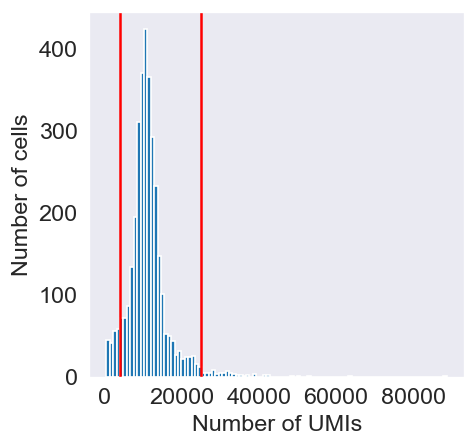

In [9]:
n, bins, *x = plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Number of UMIs")
plt.ylabel("Number of cells")
plt.axvline(4000, c="r")
plt.axvline(25000, c="r")
plt.show()

In [10]:
sc.pp.filter_cells(adata, min_counts=4000)
sc.pp.filter_cells(adata, max_counts=25000)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
adata

AnnData object with n_obs × n_vars = 3128 × 36601
    obs: 'batch', 'n_counts'
    var: 'gene_ids', 'feature_types'

In [12]:
adata.obs["batch"].value_counts()

1    1120
2    1006
0    1002
Name: batch, dtype: int64

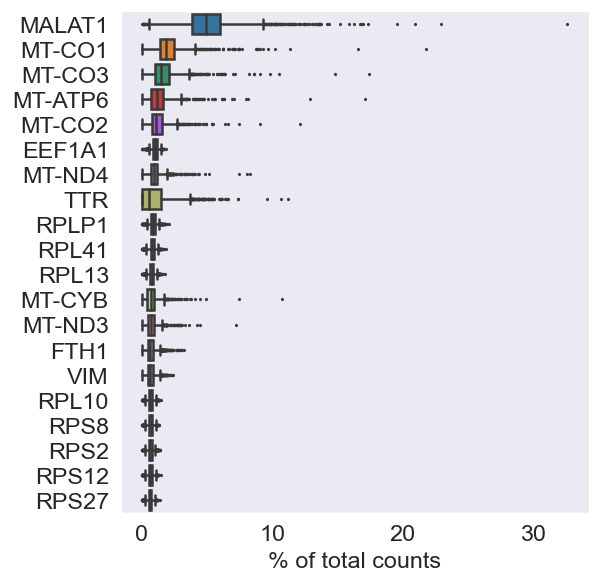

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [14]:
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes
len(expressed_genes)

3128

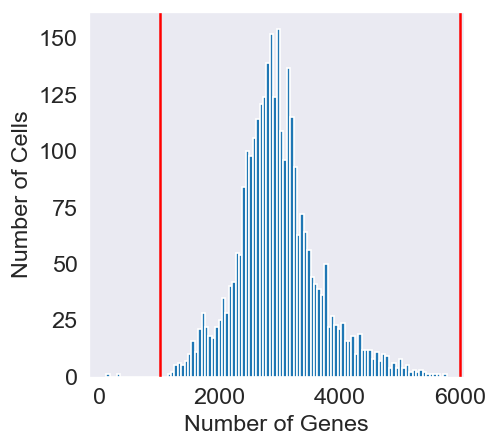

In [15]:
n, bins, *x = plt.hist(expressed_genes, bins=100)
plt.axvline(1000, c="r")
plt.axvline(6000, c="r")
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.show()

In [16]:
adata = adata[adata.obs['n_genes'] > 1000, :].copy()
adata = adata[adata.obs['n_genes'] < 6000, :].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [17]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [18]:
adata

AnnData object with n_obs × n_vars = 3126 × 36601
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types'

... storing 'feature_types' as categorical


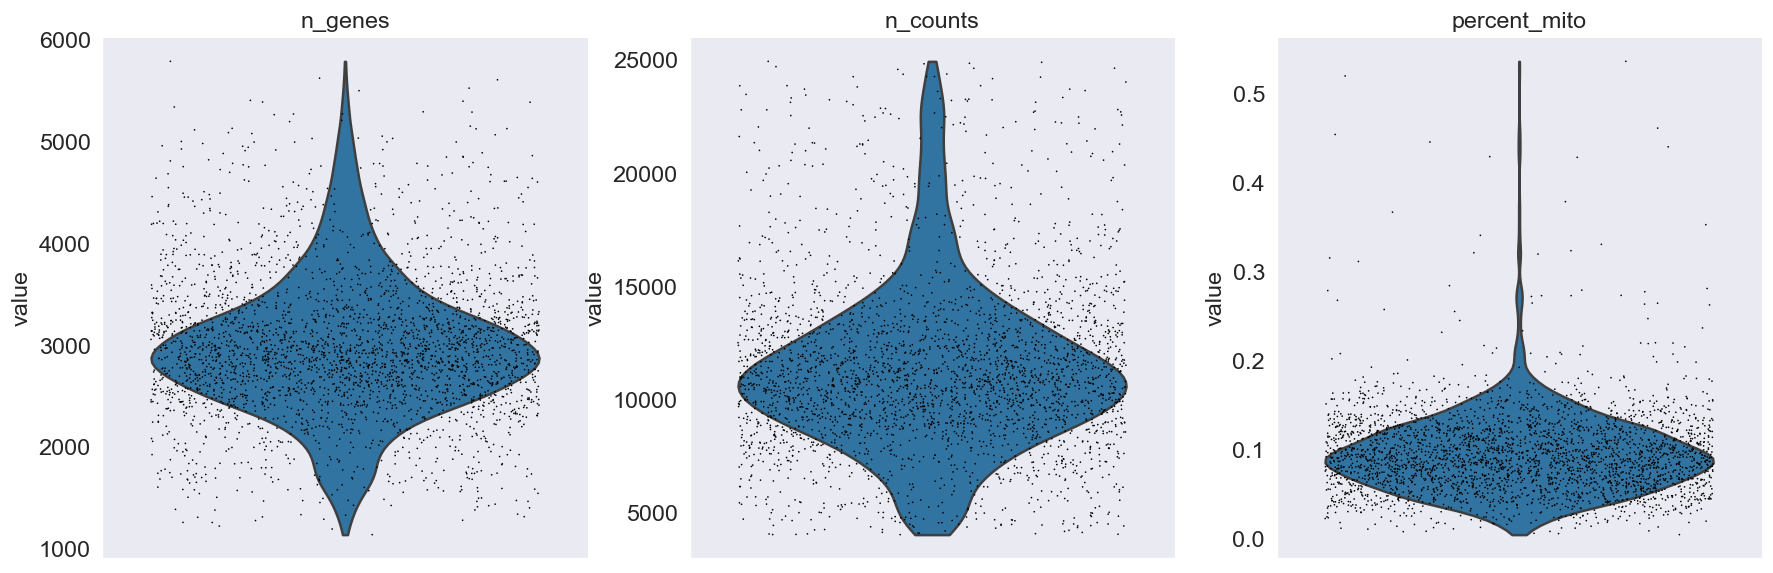

In [19]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

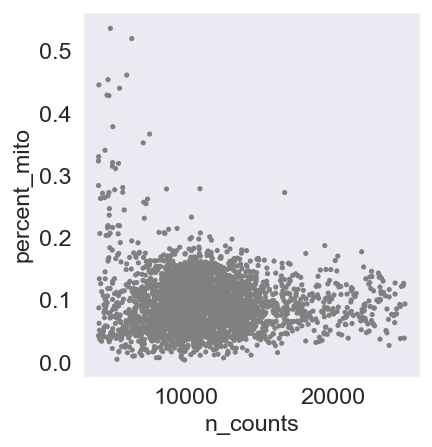

In [20]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

In [21]:
adata = adata[adata.obs['percent_mito'] < 0.20].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [22]:
adata.obs["batch"].value_counts()

1    1106
2     987
0     975
Name: batch, dtype: int64

In [23]:
adata_raw = adata.copy()

In [24]:
adata

AnnData object with n_obs × n_vars = 3068 × 36601
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types'

In [25]:
sc.pp.filter_genes(adata, min_cells=20)

In [26]:
sc.pp.normalize_total(adata)

In [27]:
adata.raw = adata

In [28]:
S_genes_hum = ["MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", 
            "MCM6", "CDCA7", "DTL", "PRIM1", "UHRF1", "CENPU", "HELLS", "RFC2", 
            "RPA2", "NASP", "RAD51AP1", "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", 
            "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", 
            "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"]
G2M_genes_hum = ["HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80",
             "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "PIMREG", 
             "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E", 
             "TUBB4B", "GTSE1", "KIF20B", "HJURP", "CDCA3", "JPT1", "CDC20", "TTK",
             "CDC25C", "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5", "CDCA2", "CDCA8", "ECT2", 
             "KIF23", "HMMR", "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5", "CENPE", 
             "CTCF", "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA"]
sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_hum, g2m_genes=G2M_genes_hum)

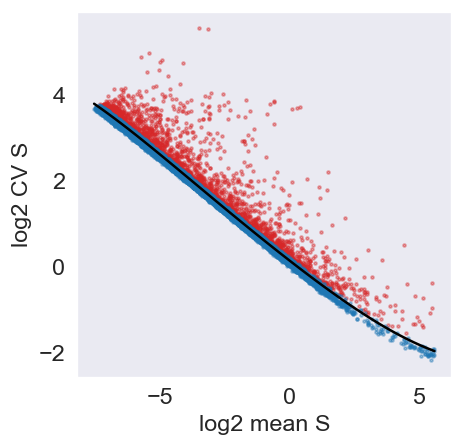

In [29]:
cv_vs_mean_keep = filter_cv_vs_mean(adata.X.toarray().T, N=2000, max_expr_avg=50)

In [30]:
sc.pp.log1p(adata)

In [31]:
adata = adata[:, cv_vs_mean_keep].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [32]:
sc.pp.regress_out(adata, ['S_score'])

... storing 'phase' as categorical


In [33]:
sc.pp.regress_out(adata, ['G2M_score'])

In [34]:
sc.pp.scale(adata, max_value=10)

In [35]:
sc.tl.pca(adata, svd_solver='arpack')

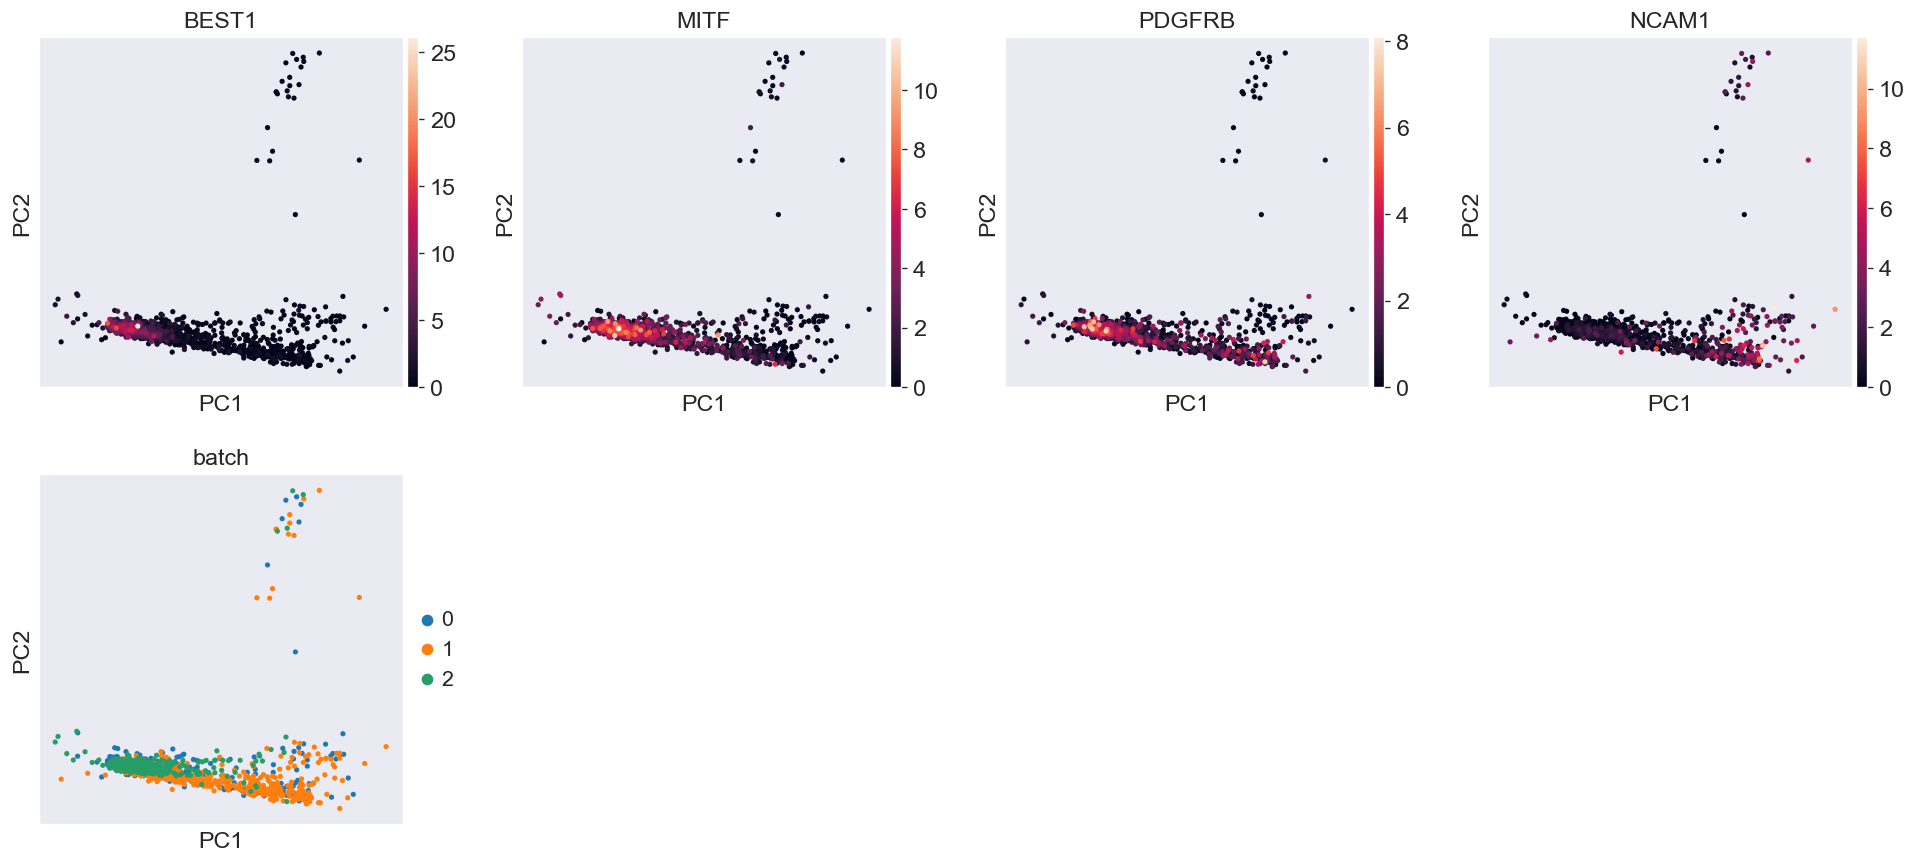

In [36]:
sc.pl.pca(adata, color=['BEST1', 'MITF', 'PDGFRB', 'NCAM1', 'batch'])

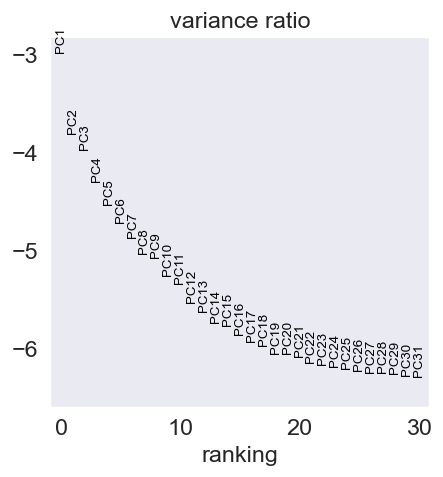

In [37]:
sc.pl.pca_variance_ratio(adata, log=True)

In [38]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=15)

In [39]:
sc.tl.umap(adata, alpha=0.3, min_dist=0.5, random_state=0)

In [40]:
sc.tl.louvain(adata, resolution=1)

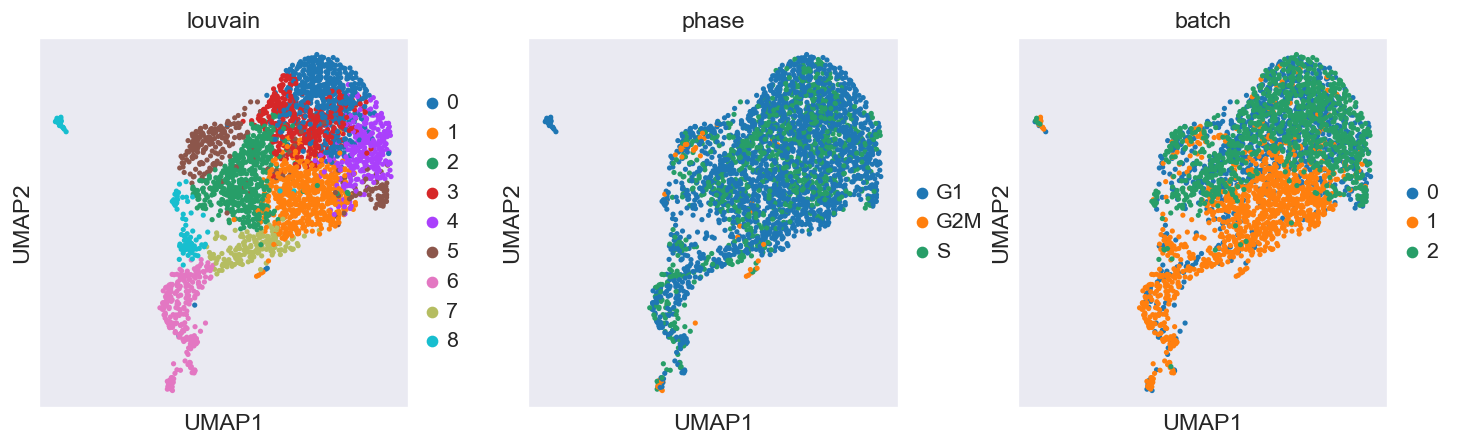

In [41]:
sc.pl.umap(adata, use_raw=True, color=['louvain', "phase", 'batch'], ncols=3)

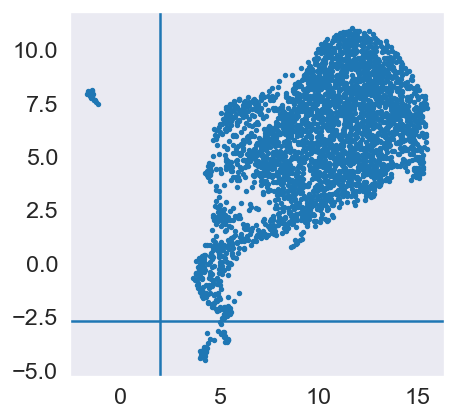

In [42]:
em = adata.obsm["X_umap"]
plt.scatter(em[:, 0], em[:, 1], s=5)
plt.axvline(2)
plt.axhline(-2.7)

In [43]:
nl = []
for i, x in zip(adata.obs["louvain"], em[:, 0]):
    if x<2:
        nl.append("9")
    else:
        nl.append(i)
adata.obs["louvain"] = nl

... storing 'louvain' as categorical


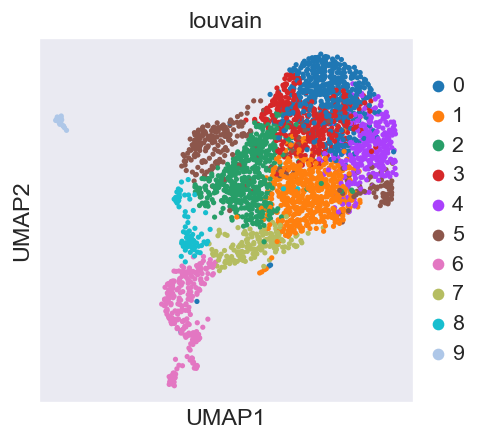

In [44]:
sc.pl.umap(adata, color='louvain')

In [45]:
nl = []
for i, x in zip(adata.obs["louvain"], em[:, 0]):
    if x>10 and i=="5":
        nl.append("10")
    else:
        nl.append(i)
adata.obs["louvain"] = nl

... storing 'louvain' as categorical


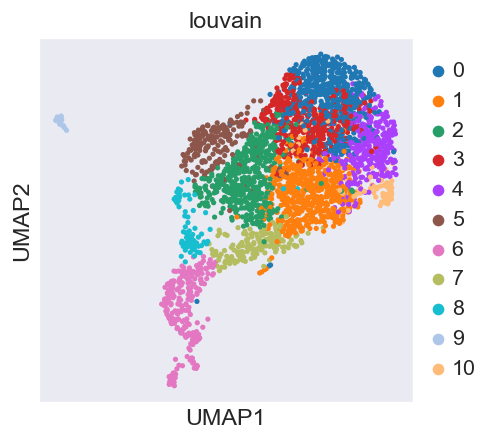

In [46]:
sc.pl.umap(adata, color='louvain')

In [47]:
nl = []
for i, y in zip(adata.obs["louvain"], em[:, 1]):
    if y<-2.7 and i=="6":
        nl.append("11")
    elif y<2.5 and i=="1":
        nl.append("7")
    else:
        nl.append(i)
adata.obs["louvain"] = nl

... storing 'louvain' as categorical


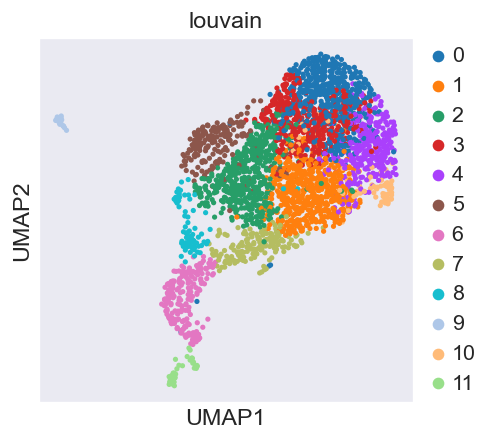

In [48]:
sc.pl.umap(adata, color='louvain')

In [49]:
adata_raw.obsm["X_umap"] = adata.obsm["X_umap"]
adata_raw.obs["louvain"] = adata.obs["louvain"]

In [50]:
adata_raw_norm = adata_raw.copy()
sc.pp.normalize_total(adata_raw_norm)
sc.pp.log1p(adata_raw_norm)

In [51]:
batch2sample = {"0":"Unsorted", "1":"NCAM1-High", "2":"CD140b-High"}
adata_raw_norm.obs['sample'] = [batch2sample[i] for i in adata_raw_norm.obs['batch']]
adata_raw.obs['sample'] = [batch2sample[i] for i in adata_raw.obs['batch']]
adata.obs['sample'] = [batch2sample[i] for i in adata.obs['batch']]

... storing 'sample' as categorical


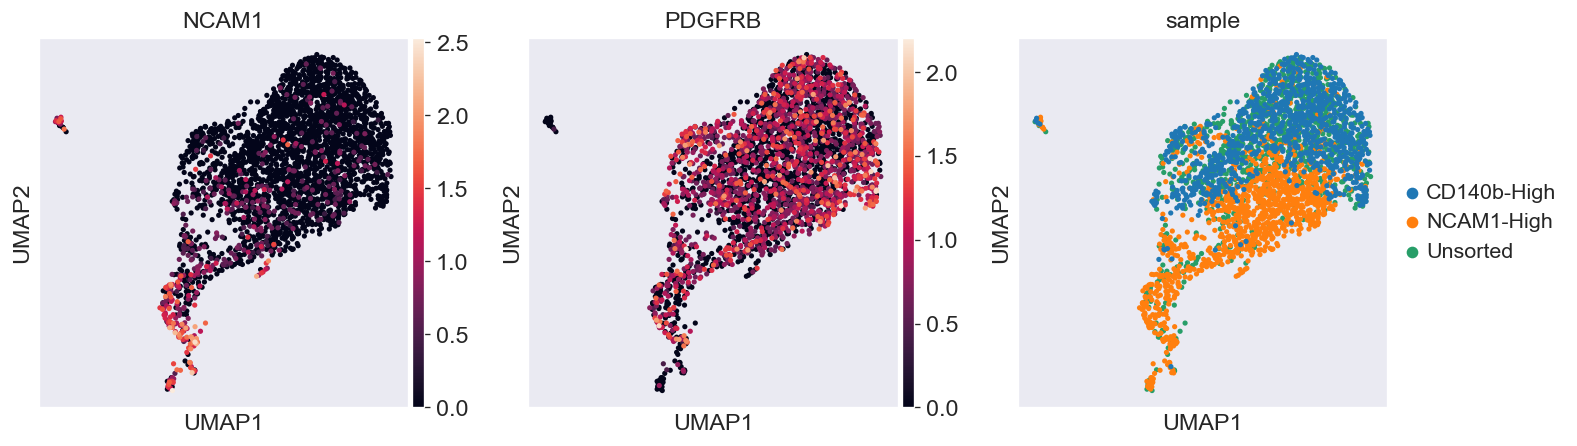

In [52]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["NCAM1", "PDGFRB", "sample"], ncols=4)

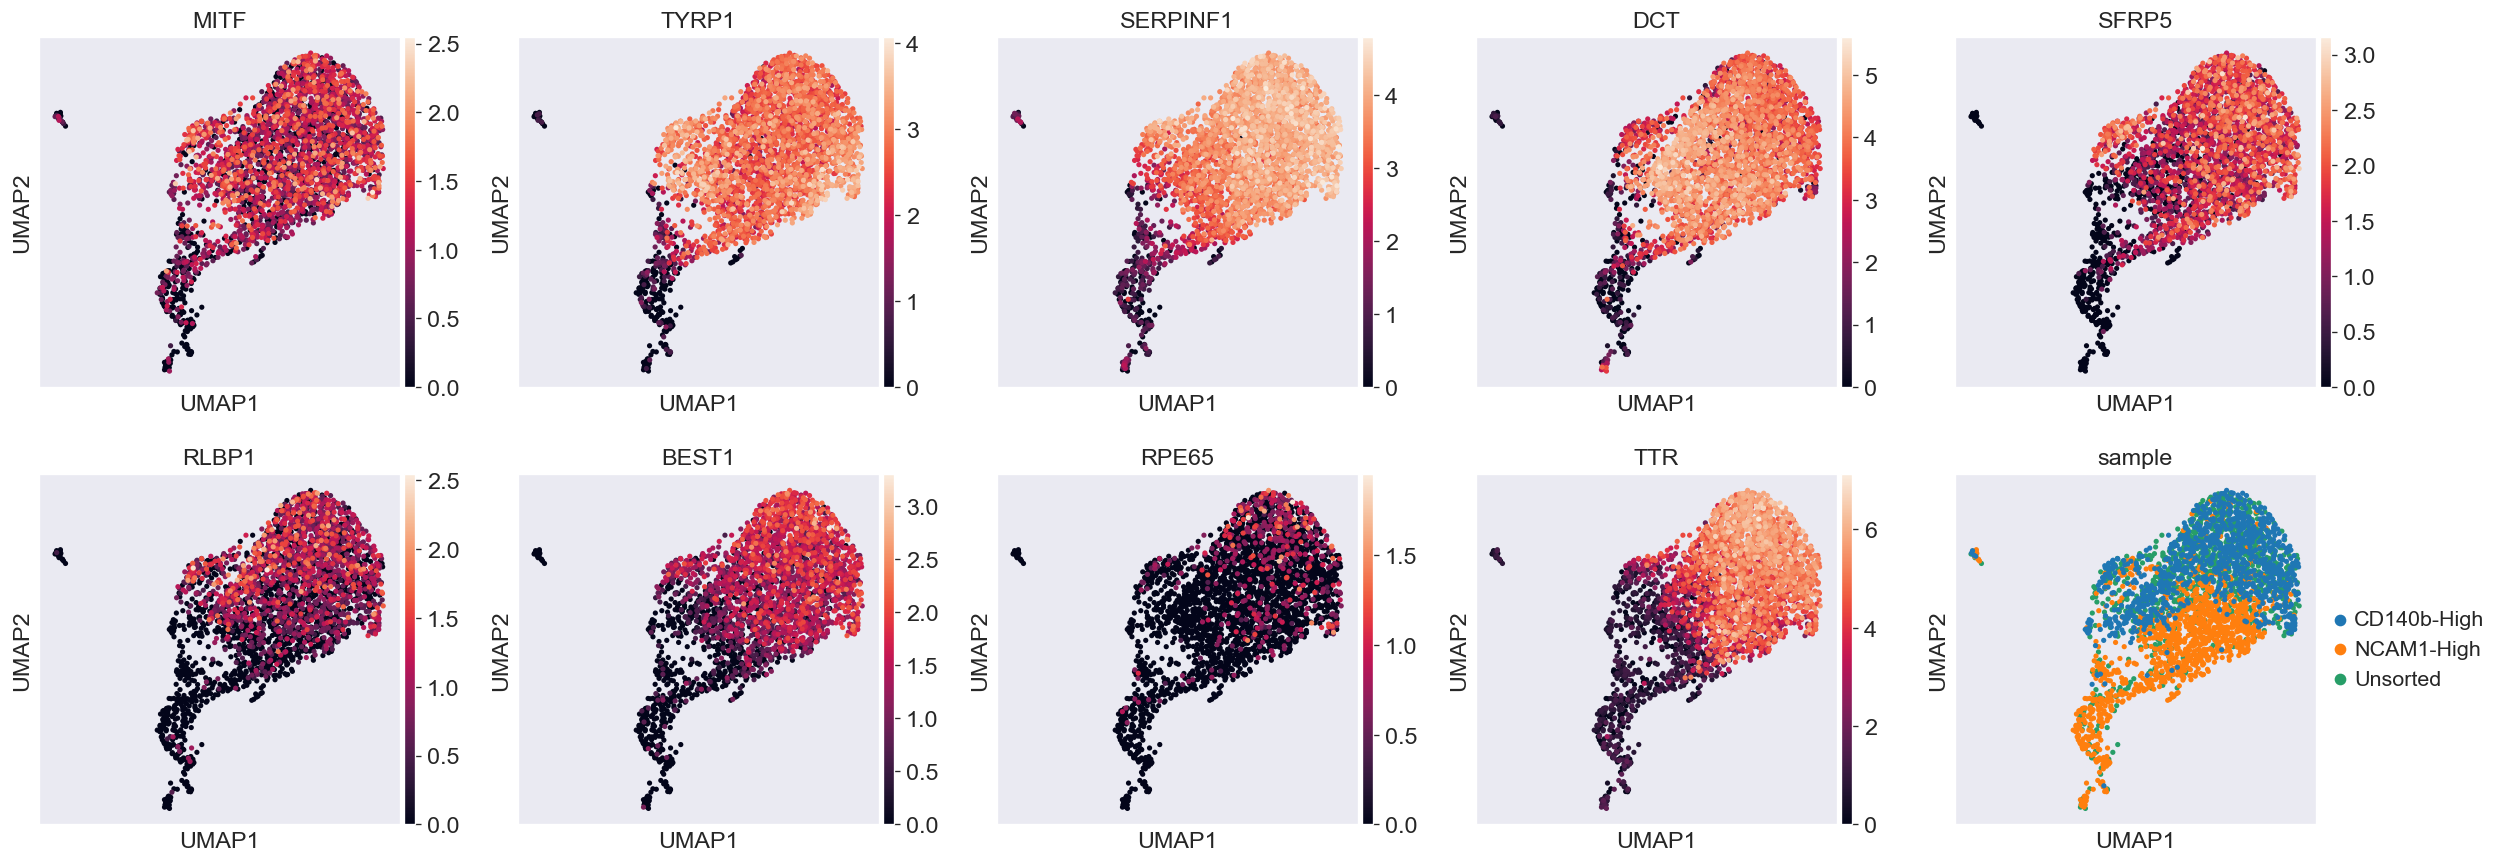

In [53]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["MITF", "TYRP1", "SERPINF1", "DCT", "SFRP5",
                                                 "RLBP1", "BEST1", "RPE65", "TTR", "sample"], ncols=5)

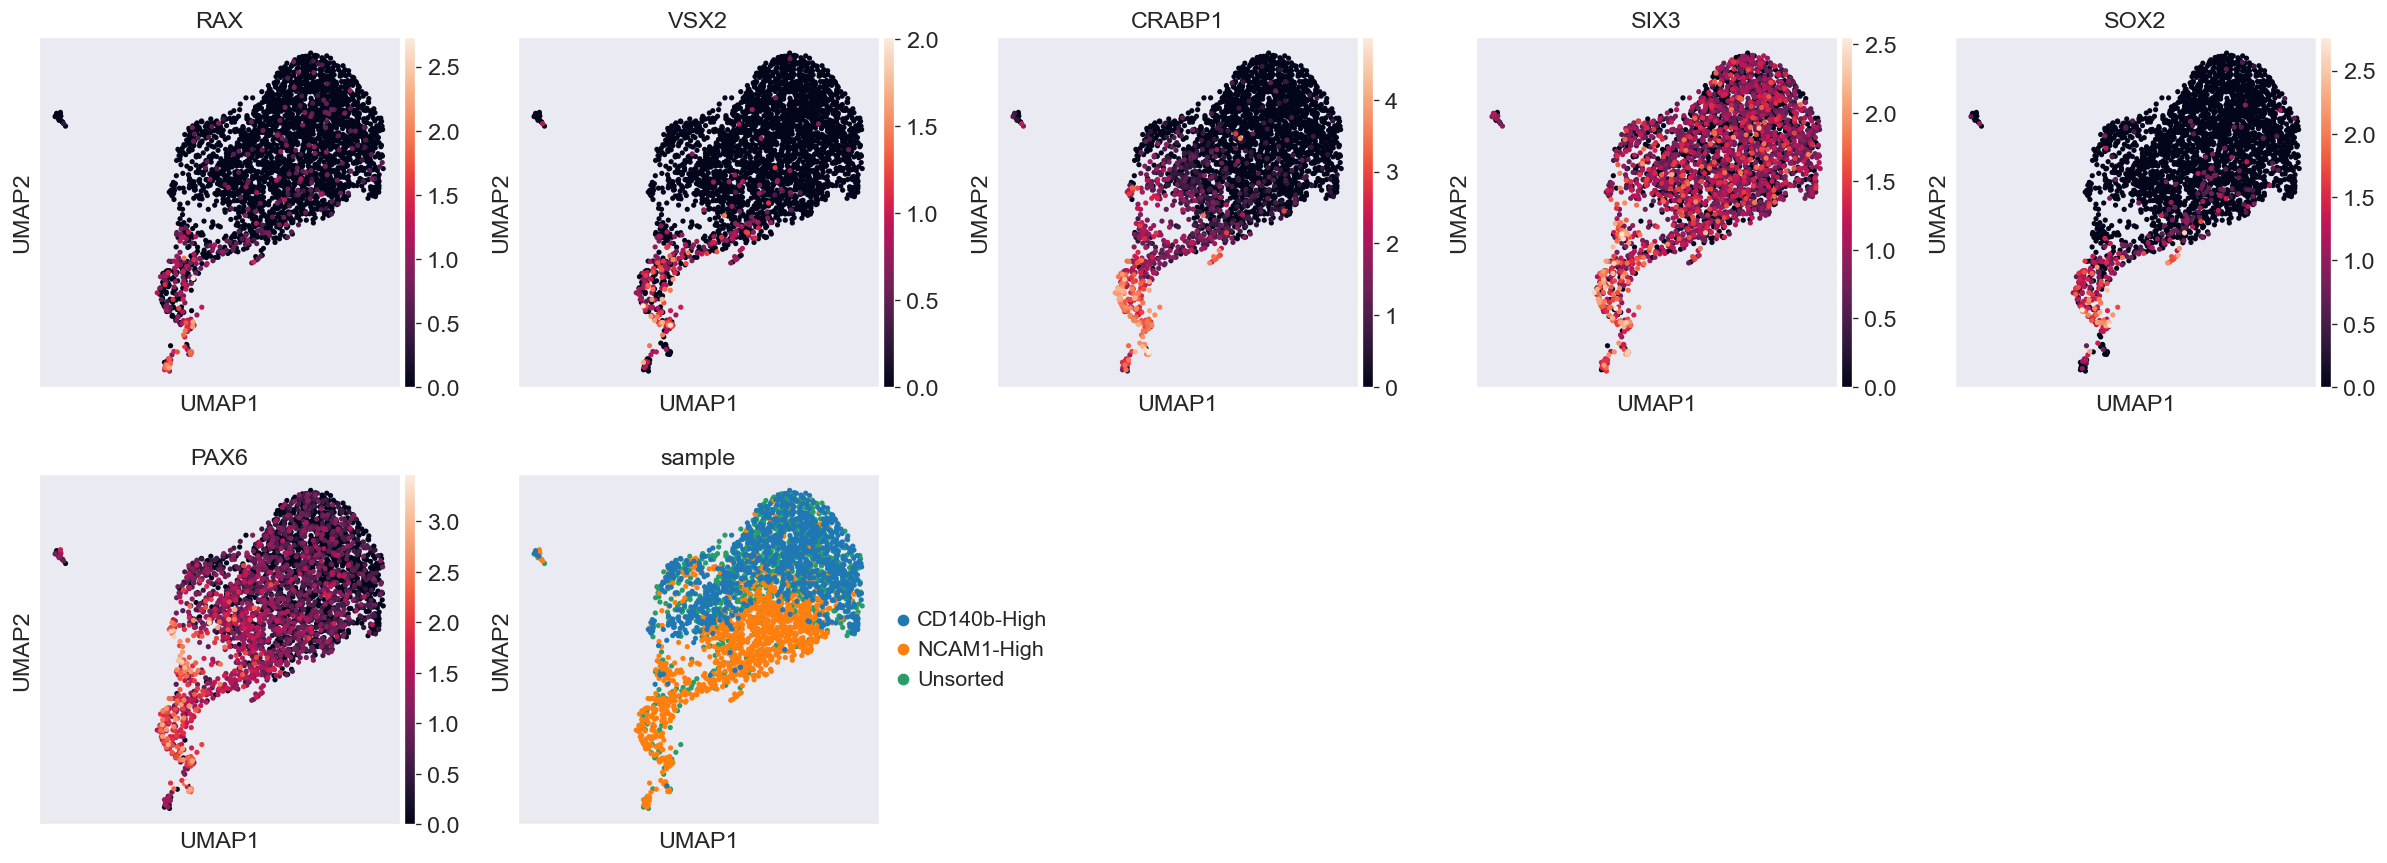

In [54]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["RAX", "VSX2", "CRABP1", "SIX3", "SOX2", "PAX6", 
                                                 "sample"], ncols=5)

In [55]:
louvain2name = {'0': "Late RPE", 
                '1': "Late RPE", 
                '10': "Late RPE", 
                '11': "Neural Retina Progenitors", 
                '2': "Mid RPE", 
                '3': "Late RPE", '4': "Late RPE", '5': "Mid RPE", '6': "Retinal Progenitors", 
                '7': "Early RPE", 
                '8': "EMT RPE", '9': "Muscle"}

In [56]:
adata_raw_norm.obs["cell_type"] = [louvain2name[i] for i in adata_raw_norm.obs["louvain"]]
adata_raw.obs["cell_type"] = [louvain2name[i] for i in adata_raw.obs["louvain"]]

... storing 'cell_type' as categorical


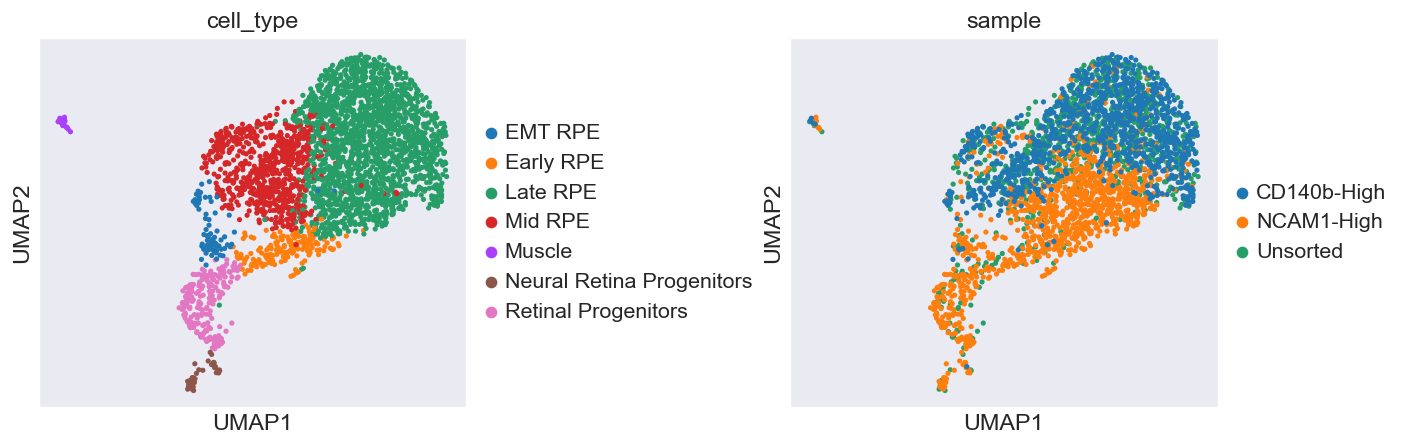

In [57]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["cell_type", "sample"], wspace=0.6, ncols=4)

(-2.5633043885231017,
 16.37597390413284,
 -5.274916124343872,
 11.778903436660766)

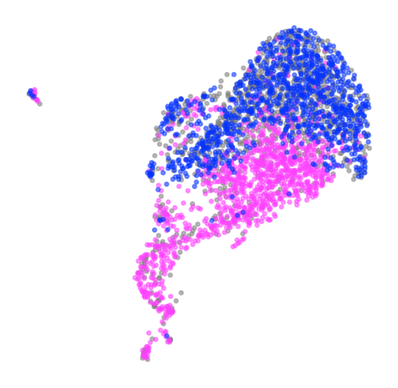

In [58]:
em = adata_raw_norm.obsm["X_umap"]
n2c = {"Unsorted":"grey", "NCAM1-High":"#ff40ff", "CD140b-High":"#0432ff"}

plt.scatter(em[:, 0], em[:, 1], c=[n2c[i] for i in adata_raw_norm.obs["sample"]], s=5, alpha=0.5, rasterized=True)
plt.axis("off")

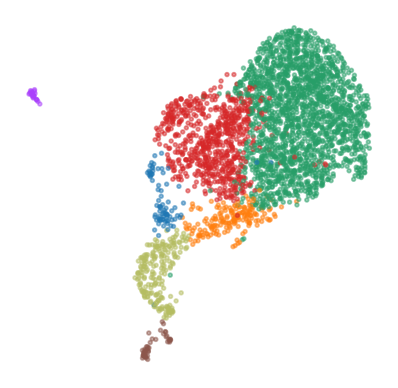

In [59]:
n2n = {'EMT RPE':'#1f77b4',
 'Early RPE': '#ff7f0e',
 'Late RPE': '#279e68',
 'Mid RPE': '#d62728',
 'Muscle': '#aa40fc',
 'Neural Retina Progenitors': '#8c564b',
 'Neuronal':'#e377c2',
 'Retinal Progenitors':'#b5bd61'}
plt.scatter(em[:, 0], em[:, 1], c=[n2n[i] for i in adata_raw_norm.obs["cell_type"]], 
            s=5, alpha=0.5, rasterized=False)
plt.axis("off")
plt.show()

In [60]:
adata_raw_norm.obs["sample"].value_counts()

NCAM1-High     1106
CD140b-High     987
Unsorted        975
Name: sample, dtype: int64

In [61]:
df = adata_raw_norm.obs
df.groupby(["cell_type", "sample"])["sample"].value_counts()/df.groupby(["sample"])["sample"].value_counts()*100

sample       sample       cell_type                
CD140b-High  CD140b-High  EMT RPE                       2.228977
                          Early RPE                     0.202634
                          Late RPE                     69.604863
                          Mid RPE                      27.456940
                          Muscle                        0.405268
                          Neural Retina Progenitors     0.101317
NCAM1-High   NCAM1-High   EMT RPE                       3.616637
                          Early RPE                    13.562387
                          Late RPE                     49.909584
                          Mid RPE                      15.099458
                          Muscle                        0.994575
                          Neural Retina Progenitors     2.531646
                          Retinal Progenitors          14.285714
Unsorted     Unsorted     EMT RPE                       1.743590
                          Early RPE   

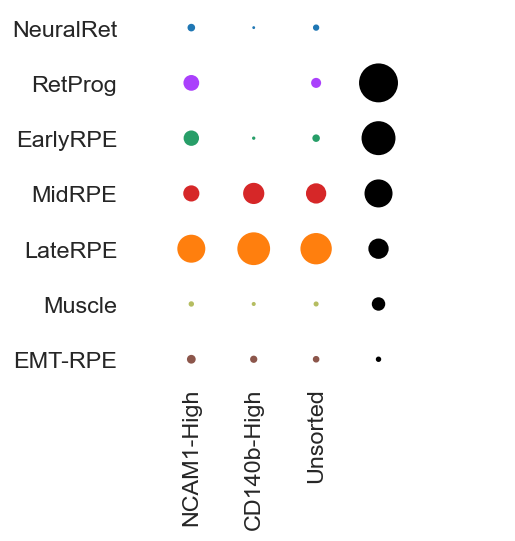

In [62]:
import matplotlib
x = [0]*7 + [1]*7 + [2]*7
y = [1, 2, 3, 4, 5, 6, 7] * 3
s = [2.531646, 14.285714, 13.562387, 15.099458, 49.909584, 0.994575, 3.616637] 
s += [0.101317, 0, 0.202634, 27.456940, 69.604863, 0.405268, 2.228977]
s += [1.538462, 5.025641, 2.461538, 24.923077, 63.487179, 0.820513, 1.743590]
c = ['#8c564b', '#b5bd61', '#ff7f0e', '#d62728', '#279e68', '#aa40fc', '#1f77b4'] * 3
xticks = ["NCAM1-High", "CD140b-High", "Unsorted"]
yticks = ["NeuralRet", "RetProg", "EarlyRPE", "MidRPE", "LateRPE", "Muscle", "EMT-RPE"]

sns.set_style("white")
plt.scatter(x[::-1]+[3]*6, y+[1, 2, 3, 4, 5, 6], s=np.array(s[::-1]+[1, 10, 25, 50, 75, 100])*5, c=c+["black"]*6)
plt.xticks(range(0, 3), xticks, rotation=90)
plt.yticks(range(1, 8), yticks[::-1])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xlim(-1, 5)
plt.show()

In [63]:
a_tmp = adata_raw_norm.copy()
a_tmp = a_tmp[a_tmp.obs["cell_type"].isin(["Late RPE"])]
a_tmp

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 1858 × 36601
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'louvain', 'sample', 'cell_type'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'sample_colors', 'cell_type_colors'
    obsm: 'X_umap'

In [64]:
from miscalg import enrichment
t2t = {"Unsorted":0, "NCAM1-High":1, "CD140b-High":2}
Xgen = a_tmp.X.toarray().T
enrichment_score = enrichment.enrichment_score(Xgen, np.array([t2t[i] for i in a_tmp.obs["sample"]]))
emarkers = enrichment.extract_enriched(enrichment_score, 
                                      np.array(a_tmp.var.index), n_enriched=10)

In [65]:
pd.DataFrame(emarkers).head(20)

0      1         2
0    MASP1   SIX6    CYP2W1
1     GPAM    ID1     WFDC1
2    GCNT1   RMST  C11orf88
3      CCK   HMX1     PRKCB
4     FGF7   SOX2      NRP2
5  C1orf61    ID3     DLEU7
6    DHX34  ANXA1   FAM181B
7     OC90   LHX9      DPP6
8   TBC1D4    MAL     GNA14
9   ENTPD2  EDIL3     MTUS2

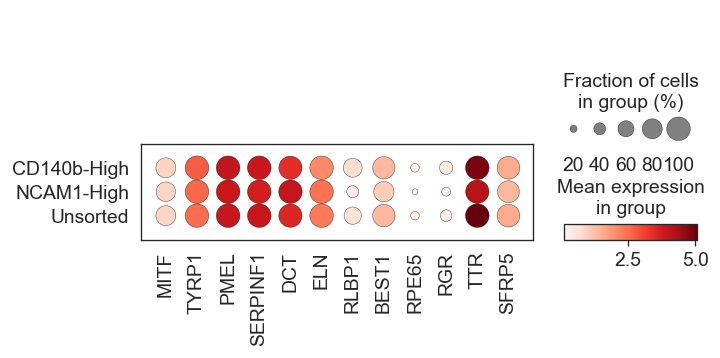

In [66]:
markers =  ["MITF", "TYRP1", "PMEL", "SERPINF1", "DCT", "ELN",
            "RLBP1", "BEST1", "RPE65", "RGR", "TTR", "SFRP5"]
sc.pl.dotplot(a_tmp, markers, groupby='sample',
                     dendrogram=False)

In [67]:
n2i = {'EMT RPE': 2,
 'Early RPE': 3,
 'Late RPE': 5,
 'Mid RPE': 4,
 'Muscle': 6,
 'Neural Retina Progenitors': 0,
 'Retinal Progenitors': 1}

In [68]:
from miscalg import enrichment
Xgen = adata_raw.X.toarray().T
enrichment_score = enrichment.enrichment_score(Xgen, np.array([n2i[i] for i in adata_raw.obs["cell_type"]]))
emarkers = enrichment.extract_enriched(enrichment_score, 
                                      np.array(adata_raw.var.index), n_enriched=20)

pd.DataFrame(emarkers)

0          1           2          3           4          5  \
0       STMN2      SFRP2       ACTA2       SIX6       BCAS1    SLC6A13   
1     NEUROD4       SPP1      IGFBP3      EDNRB         SST       ERMN   
2     NEUROD1       HES5        ZIC1       TLL1       TFPI2      DUSP4   
3         VXN       CRB1       TAGLN        OAF       GNGT1  LINC01202   
4   LINC00599         CP       LYPD1        MAL        PNOC      ADAD2   
5        SCG3     SORCS1      COL3A1       GCGR       SYT10  LINC00276   
6      TLCD3B     PRSS35      PDGFRA      SLIT1        BNC1    WFIKKN2   
7       RCVRN    BHLHE22       CADPS       VCAN         NPW      HMOX1   
8     ONECUT1  LINC02500        EDN1   NDUFA4L2       BFSP2      SMOC2   
9        CHGB       SOX2         H19   HIST1H3B         DCN      TTLL4   
10      PRDM1     MARCH3     C5orf46  LINC01474       UPK3B      ADTRP   
11        PRL     ATP1A2   LINC01474       RRM2        BCAN   SLC39A12   
12       SYT4     IFI44L       CHSY3       HMX1        PRPH    SLC13A4   
13    ONECUT2      FEZF2      CPAMD8     SLC5A8        CDH1      CDH19   
14      ATOH7      SYNPR       CARMN     NECAB2         CFH        TTR   
15       THRB       VSX2         MGP       NBL1       HAND2        HBZ   
16        PDC      NRCAM        NPR3      IGFN1         NMU        CRX   
17        INA       DKK1  AC092958.1       VSX2  AC092384.1      RPE65   
18      STMN4       BEX1      COL1A1   CELF2-DT       CPLX3      GNA14   
19       GSG1    PHYHIPL         DCN      AURKB     COL14A1      KCNE2   

             6  
0         MYL1  
1         MYH3  
2        ACTA1  
3        TNNI2  
4        MYLPF  
5        TNNC2  
6        ACTC1  
7         MYH8  
8        TNNT3  
9          CKM  
10         NEB  
11      KLHL41  
12       MEF2C  
13        MYL4  
14  AC020909.2  
15         TTN  
16        SMPX  
17     COL19A1  
18        CAV3  
19       IL17B

In [69]:
genes = ["STMN2", "NEUROD4", "NEUROD1", "RCVRN", "ONECUT1", "ATOH7",
        "SFRP2", "HES5", "SOX2", "VSX2", "CRB1", "FEZF2",
        "ACTA2", "ZIC1", "TAGLN", "LYPD1", "COL4A1", "PDGFRA",
         "TMEFF2", "MITF", "DCT", "TYRP1", "PMEL", "TYR", "RLBP1", "BEST1", "RBP1",
        "RPE65", "TTR", "RGR", "SLC6A13", "SFRP5",
        "MYL1", "MYH3", "ACTA1", "TNNI2", "TNNC2"]
X = pd.DataFrame(adata_raw_norm[:, genes].X.toarray())
X.index = adata_raw_norm.obs["cell_type"]
X.columns = genes
X = X.groupby(X.index).mean()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [70]:
X = X.loc[["Neural Retina Progenitors", "Retinal Progenitors", "EMT RPE", 
           "Early RPE", "Mid RPE", "Late RPE", "Muscle"]]

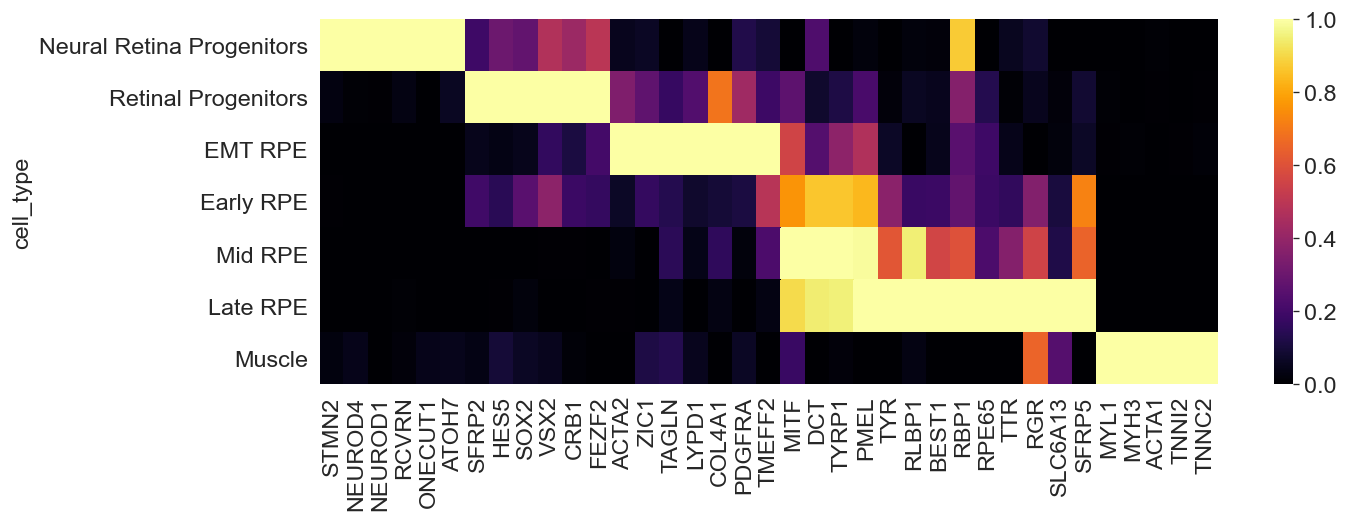

In [71]:
plt.figure(None, (12, 4))
sns.heatmap((X - X.min()) / (X.max() - X.min()), cmap='inferno')
plt.show()